In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import re
import sys
import pickle
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from data_loader import get_loader
from torchvision import transforms
from margin_exp import train_model, plot
from network import ResNet18, CNN
import seaborn as sns
from utils import ramp_loss, margin_error

use_gpu = torch.cuda.is_available()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 400 channels - 10% noise

In [8]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 400
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_01, log_01 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

****** label mode: partially-0.1 ******
total parameters: 5780810
Epoch 1/100
----------
train1: CrossEntropy: 1.4150, Error: 0.4713, Lip(pow):4.0181
test: CrossEntropy: 1.5014, Error: 0.4999, Lip(pow):4.0181
Epoch 2/100
----------
train1: CrossEntropy: 1.2030, Error: 0.3765, Lip(pow):2.9228
test: CrossEntropy: 1.3908, Error: 0.4549, Lip(pow):2.9228
Epoch 3/100
----------
train1: CrossEntropy: 1.0133, Error: 0.3042, Lip(pow):3.1328
test: CrossEntropy: 1.3292, Error: 0.4239, Lip(pow):3.1328
Epoch 4/100
----------
train1: CrossEntropy: 0.8694, Error: 0.2572, Lip(pow):3.6227
test: CrossEntropy: 1.3322, Error: 0.4170, Lip(pow):3.6227
Epoch 5/100
----------
train1: CrossEntropy: 0.7301, Error: 0.2090, Lip(pow):4.0873
test: CrossEntropy: 1.3679, Error: 0.4191, Lip(pow):4.0873
Epoch 6/100
----------
train1: CrossEntropy: 0.5781, Error: 0.1651, Lip(pow):4.7766
test: CrossEntropy: 1.4296, Error: 0.4254, Lip(pow):4.7766
Epoch 7/100
----------
train1: CrossEntropy: 0.4495, Error: 0.1272, Lip(pow)

train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):14.1911
test: CrossEntropy: 2.2188, Error: 0.4200, Lip(pow):14.1911
Epoch 58/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):14.2786
test: CrossEntropy: 2.2312, Error: 0.4210, Lip(pow):14.2786
Epoch 59/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):14.1606
test: CrossEntropy: 2.2213, Error: 0.4199, Lip(pow):14.1606
Epoch 60/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):14.2641
test: CrossEntropy: 2.2282, Error: 0.4196, Lip(pow):14.2641
Epoch 61/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):14.1906
test: CrossEntropy: 2.2273, Error: 0.4197, Lip(pow):14.1906
Epoch 62/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):14.4693
test: CrossEntropy: 2.2394, Error: 0.4200, Lip(pow):14.4693
Epoch 63/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):14.3552
test: CrossEntropy: 2.2376, Error: 0.4189, Lip(pow):14.3552
Ep

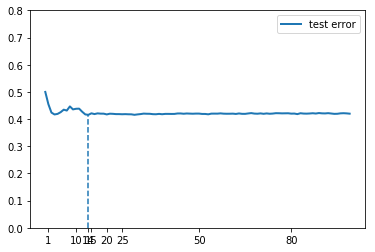

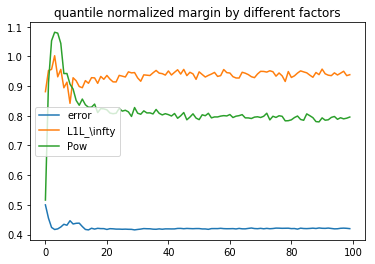

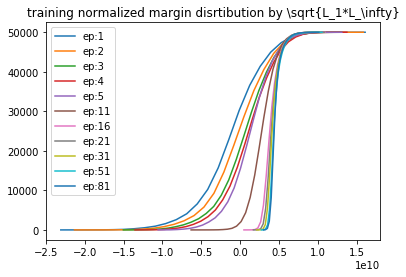

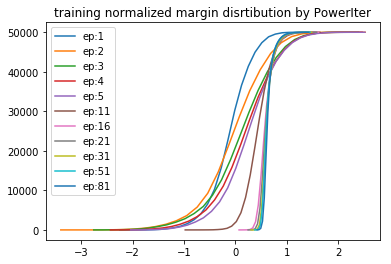

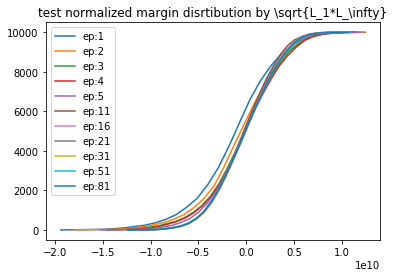

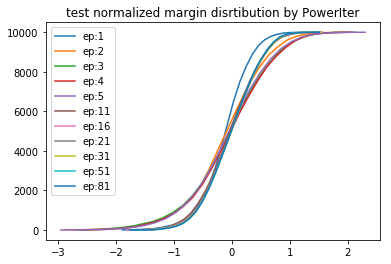

In [41]:
log = log_01

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 0.90
plt.plot(log['test_error'], label='error')
nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1/6e9, q, axis=1), label='L1L_\infty')
plt.plot(log['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.title('quantile normalized margin by different factors')
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('training normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('training normalized margin disrtibution by PowerIter')
plt.show()


for ep in ep_list:
    nmargin_l1 = np.array(log['test_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('test normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('test normalized margin disrtibution by PowerIter')
plt.show()


# 400 channels - 0% noise

In [22]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 400
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_00, log_00 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

****** label mode: original ******
total parameters: 5780810
Epoch 1/100
----------
train1: CrossEntropy: 1.1542, Error: 0.3979, Lip(pow):6.4282
test: CrossEntropy: 1.2454, Error: 0.4429, Lip(pow):6.4282
Epoch 2/100
----------
train1: CrossEntropy: 0.8870, Error: 0.3008, Lip(pow):5.2375
test: CrossEntropy: 1.0609, Error: 0.3713, Lip(pow):5.2375
Epoch 3/100
----------
train1: CrossEntropy: 0.7038, Error: 0.2390, Lip(pow):5.8522
test: CrossEntropy: 0.9881, Error: 0.3489, Lip(pow):5.8522
Epoch 4/100
----------
train1: CrossEntropy: 0.5238, Error: 0.1640, Lip(pow):6.0591
test: CrossEntropy: 0.9137, Error: 0.3192, Lip(pow):6.0591
Epoch 5/100
----------
train1: CrossEntropy: 0.3929, Error: 0.1196, Lip(pow):6.7359
test: CrossEntropy: 0.9158, Error: 0.3144, Lip(pow):6.7359
Epoch 6/100
----------
train1: CrossEntropy: 0.2739, Error: 0.0783, Lip(pow):7.8479
test: CrossEntropy: 0.9252, Error: 0.3147, Lip(pow):7.8479
Epoch 7/100
----------
train1: CrossEntropy: 0.1939, Error: 0.0513, Lip(pow):8.79

train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):17.9317
test: CrossEntropy: 1.2567, Error: 0.2950, Lip(pow):17.9317
Epoch 58/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):17.9414
test: CrossEntropy: 1.2593, Error: 0.2958, Lip(pow):17.9414
Epoch 59/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):17.7457
test: CrossEntropy: 1.2549, Error: 0.2953, Lip(pow):17.7457
Epoch 60/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):17.7412
test: CrossEntropy: 1.2579, Error: 0.2956, Lip(pow):17.7412
Epoch 61/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):17.7962
test: CrossEntropy: 1.2628, Error: 0.2964, Lip(pow):17.7962
Epoch 62/100
----------
train1: CrossEntropy: 0.0003, Error: 0.0000, Lip(pow):18.0303
test: CrossEntropy: 1.2586, Error: 0.2956, Lip(pow):18.0303
Epoch 63/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):18.2040
test: CrossEntropy: 1.2639, Error: 0.2965, Lip(pow):18.2040
Ep

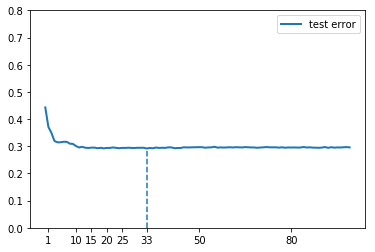

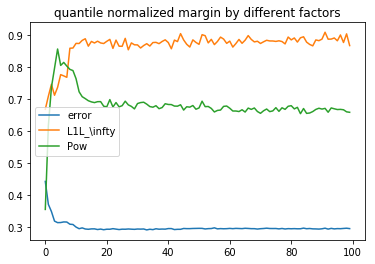

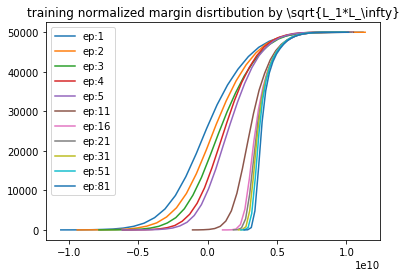

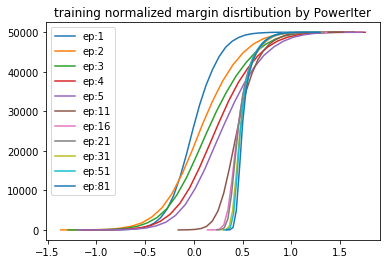

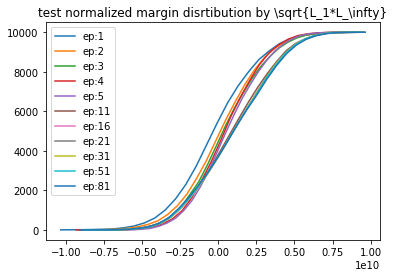

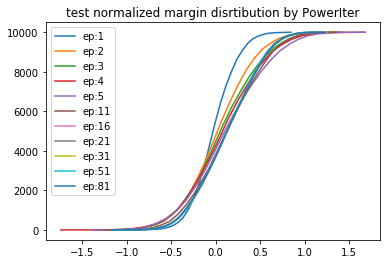

In [52]:
log = log_00

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 0.90
plt.plot(log['test_error'], label='error')
nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1/6e9, q, axis=1), label='L1L_\infty')
plt.plot(log['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.title('quantile normalized margin by different factors')
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('training normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('training normalized margin disrtibution by PowerIter')
plt.show()


for ep in ep_list:
    nmargin_l1 = np.array(log['test_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('test normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('test normalized margin disrtibution by PowerIter')
plt.show()


## 800channels - 10% noise

In [27]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 800
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_03, log_03 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

****** label mode: partially-0.1 ******
total parameters: 23081610
Epoch 1/100
----------
train1: CrossEntropy: 1.3509, Error: 0.4431, Lip(pow):3.8554
test: CrossEntropy: 1.4677, Error: 0.4870, Lip(pow):3.8554
Epoch 2/100
----------
train1: CrossEntropy: 1.1137, Error: 0.3401, Lip(pow):3.2644
test: CrossEntropy: 1.3570, Error: 0.4311, Lip(pow):3.2644
Epoch 3/100
----------
train1: CrossEntropy: 0.8818, Error: 0.2554, Lip(pow):3.6785
test: CrossEntropy: 1.3078, Error: 0.4049, Lip(pow):3.6785
Epoch 4/100
----------
train1: CrossEntropy: 0.7010, Error: 0.1943, Lip(pow):3.7788
test: CrossEntropy: 1.3507, Error: 0.4201, Lip(pow):3.7788
Epoch 5/100
----------
train1: CrossEntropy: 0.5228, Error: 0.1439, Lip(pow):4.7331
test: CrossEntropy: 1.4382, Error: 0.4273, Lip(pow):4.7331
Epoch 6/100
----------
train1: CrossEntropy: 0.3602, Error: 0.1025, Lip(pow):5.6562
test: CrossEntropy: 1.5390, Error: 0.4288, Lip(pow):5.6562
Epoch 7/100
----------
train1: CrossEntropy: 0.2099, Error: 0.0548, Lip(pow

train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):11.9200
test: CrossEntropy: 2.0601, Error: 0.3964, Lip(pow):11.9200
Epoch 58/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):11.9907
test: CrossEntropy: 2.0591, Error: 0.3957, Lip(pow):11.9907
Epoch 59/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):11.9345
test: CrossEntropy: 2.0641, Error: 0.3960, Lip(pow):11.9345
Epoch 60/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):11.9091
test: CrossEntropy: 2.0602, Error: 0.3957, Lip(pow):11.9091
Epoch 61/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):11.9873
test: CrossEntropy: 2.0575, Error: 0.3950, Lip(pow):11.9873
Epoch 62/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):11.8682
test: CrossEntropy: 2.0646, Error: 0.3959, Lip(pow):11.8682
Epoch 63/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):11.9032
test: CrossEntropy: 2.0715, Error: 0.3961, Lip(pow):11.9032
Ep

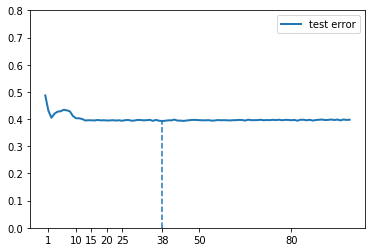

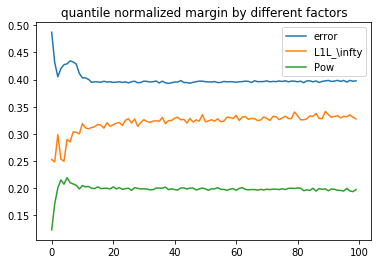

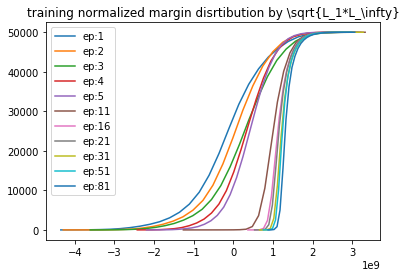

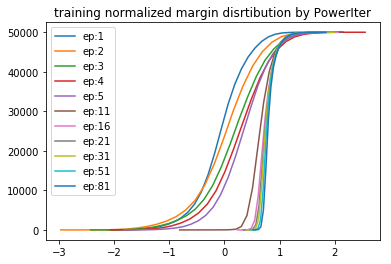

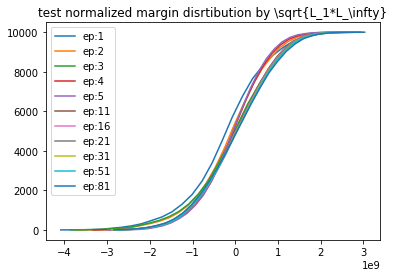

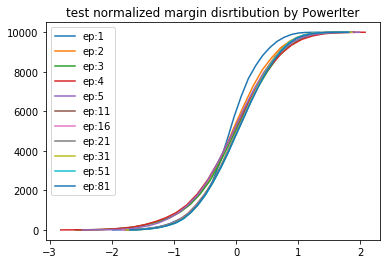

In [50]:
log = log_03

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = .9
plt.plot(log['test_error'], label='error')
nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1/5e9, q, axis=1), label='L1L_\infty')
plt.plot(np.array(log['train_qnmargin_%.1f'%q])/5, label='Pow')
plt.legend()
plt.title('quantile normalized margin by different factors')
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('training normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('training normalized margin disrtibution by PowerIter')
plt.show()


for ep in ep_list:
    nmargin_l1 = np.array(log['test_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('test normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('test normalized margin disrtibution by PowerIter')
plt.show()


## 800channels - 0% noise

In [28]:
# %%
root = './data'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

# %% run the model
num_epochs = 100
channels = 800
# here use with_bn to control batch normalisation
model = CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model_04, log_04 = train_model(model, criterion, optimizer, loaders, 
                               num_epochs=100, verbose=True, net='CNN')

****** label mode: original ******
total parameters: 23081610
Epoch 1/100
----------
train1: CrossEntropy: 1.0621, Error: 0.3675, Lip(pow):5.6120
test: CrossEntropy: 1.1542, Error: 0.4082, Lip(pow):5.6120
Epoch 2/100
----------
train1: CrossEntropy: 0.7749, Error: 0.2618, Lip(pow):4.2015
test: CrossEntropy: 0.9972, Error: 0.3523, Lip(pow):4.2015
Epoch 3/100
----------
train1: CrossEntropy: 0.5392, Error: 0.1730, Lip(pow):5.0316
test: CrossEntropy: 0.9029, Error: 0.3107, Lip(pow):5.0316
Epoch 4/100
----------
train1: CrossEntropy: 0.3768, Error: 0.1139, Lip(pow):5.2962
test: CrossEntropy: 0.9007, Error: 0.3102, Lip(pow):5.2962
Epoch 5/100
----------
train1: CrossEntropy: 0.2318, Error: 0.0639, Lip(pow):6.6056
test: CrossEntropy: 0.9440, Error: 0.3126, Lip(pow):6.6056
Epoch 6/100
----------
train1: CrossEntropy: 0.1469, Error: 0.0379, Lip(pow):7.3373
test: CrossEntropy: 0.9817, Error: 0.3083, Lip(pow):7.3373
Epoch 7/100
----------
train1: CrossEntropy: 0.0663, Error: 0.0137, Lip(pow):8.6

train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):13.8396
test: CrossEntropy: 1.1318, Error: 0.2727, Lip(pow):13.8396
Epoch 58/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):13.8377
test: CrossEntropy: 1.1345, Error: 0.2744, Lip(pow):13.8377
Epoch 59/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):14.1906
test: CrossEntropy: 1.1405, Error: 0.2755, Lip(pow):14.1906
Epoch 60/100
----------
train1: CrossEntropy: 0.0002, Error: 0.0000, Lip(pow):13.8508
test: CrossEntropy: 1.1337, Error: 0.2739, Lip(pow):13.8508
Epoch 61/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(pow):14.1049
test: CrossEntropy: 1.1433, Error: 0.2742, Lip(pow):14.1049
Epoch 62/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(pow):14.2384
test: CrossEntropy: 1.1429, Error: 0.2728, Lip(pow):14.2384
Epoch 63/100
----------
train1: CrossEntropy: 0.0001, Error: 0.0000, Lip(pow):13.7848
test: CrossEntropy: 1.1472, Error: 0.2741, Lip(pow):13.7848
Ep

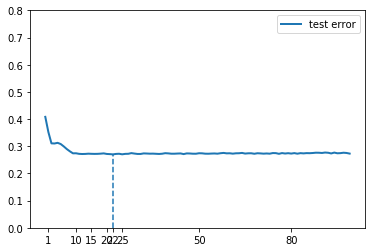

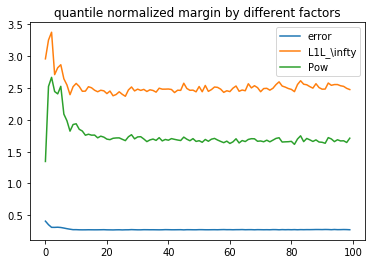

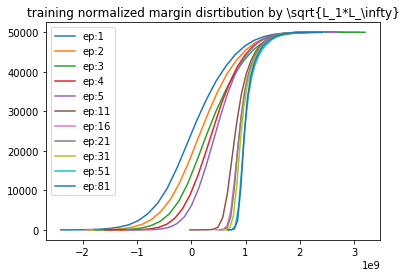

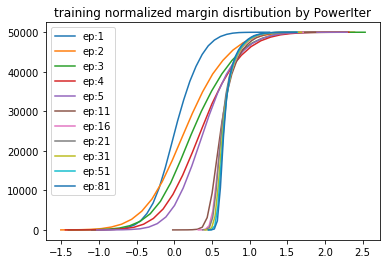

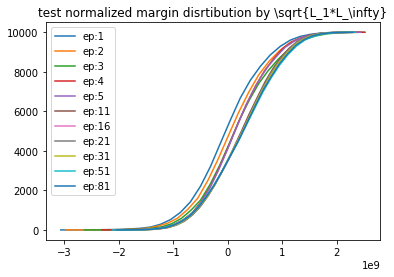

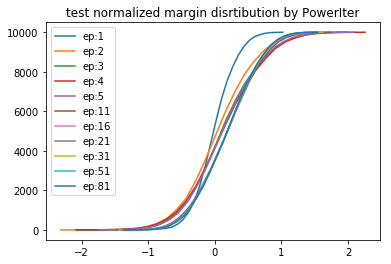

In [45]:
log = log_04

#plt.plot(log['train_error'], linewidth=2, label='training')

plt.plot(log['test_error'], linewidth=2, label='test error', c='C0')
min_idx_1 = np.argmin(log['test_error'])
plt.plot([min_idx_1, min_idx_1], [0, log['test_error'][min_idx_1]], '--', c='C0' )
plt.ylim(0,.8)
plt.xticks([1, min_idx_1, 10, 15, 20, 25, 50, 80], [1, min_idx_1, 10, 15, 20, 25, 50, 80])
plt.legend()
plt.show()

q = 1.0
plt.plot(log['test_error'], label='error')
nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
plt.plot(np.quantile(nmargin_l1/1e9, q, axis=1), label='L1L_\infty')
plt.plot(log['train_qnmargin_%.1f'%q], label='Pow')
plt.legend()
plt.title('quantile normalized margin by different factors')
plt.show()


ep_list = [0, 1,2,3,4,10,15,20,30,50,80]
for ep in ep_list:
    nmargin_l1 = np.array(log['train_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('training normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['train_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('training normalized margin disrtibution by PowerIter')
plt.show()


for ep in ep_list:
    nmargin_l1 = np.array(log['test_dist_margin'])/np.array(log['lip_l1']).reshape(100,1)
    value, base = np.histogram(nmargin_l1[ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    #plt.xlim(0,1)
    plt.legend()
    plt.title('test normalized margin disrtibution by \sqrt{L_1*L_\infty}')
plt.show()

for ep in ep_list:
    value, base = np.histogram(log['test_dist_nmargin'][ep], bins=30)
    cdf = np.cumsum(value)
    plt.plot(base[:-1], cdf, label='ep:%d'%(ep+1))
    plt.legend()
    plt.title('test normalized margin disrtibution by PowerIter')
plt.show()
